### 순서
##### 1. 종속변수 라벨링
##### 2. 내생변수 및 중요하지 않은 변수 삭제
##### 3. 문자형 변수 처리 -> 숫자형 or 더미화
##### 4. 숫자형 변수 처리 -> 결측치 평균/중앙값으로 채우거나 nanflag 이진변수 생성
##### 5. 히스토그램으로 분포 확인 -> 필요시 정규화 및 클리핑

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import seaborn as sns

In [2]:
# 컬럼과 행을 모두 다 출력할 수 있도록 설정
pd.set_option('display.max_columns', None)  # 열 생략 없이 보기
pd.set_option('display.max_rows', None)     # 행 생략 없이 보기
pd.set_option('display.max_colwidth', None) # 컬럼 너비 제한 해제


In [3]:
df = pd.read_csv('../data/raw/lending_club_2020_train.csv', low_memory = False)
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,124989905,6000.0,6000.0,6000.0,36 months,7.97%,187.94,A,A5,Teacher,2 years,MORTGAGE,45000.0,Verified,Dec-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=124989905,debt_consolidation,Debt consolidation,554xx,MN,8.67,1.0,Sep-2005,755.0,759.0,0.0,22.0,NaN,14.0,0.0,3090.0,14%,36.0,w,0.00,0.00,6718.84,6718.84,6000.00,718.84,0.0,0.0,0.0,Apr-2020,1835.06,NaN,Apr-2020,764.0,760.0,0.0,NaN,1.0,Joint App,100500.0,10.20,Verified,0.0,0.0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,3090.0,64.0,22100.0,1.0,0.0,2.0,4.0,3850.0,11910.0,20.6,0.0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,NaN,3.0,NaN,0.0,1.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0.0,0.0,0.0,4.0,97.1,0.0,0.0,0.0,78611.0,50054.0,15000.0,56511.0,3926.0,555.0,559.0,Sep-2005,0.0,0.0,10.0,NaN,10.0,4.0,1.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,139665484,35000.0,35000.0,35000.0,60 months,14.47%,822.95,C,C2,Product Specialist,2 years,RENT,94000.0,Source Verified,Sep-2018,Current,n,https://lendingclub.com/browse/loanDetail.action?loan_id=139665484,credit_card,Credit card refinancing,085xx,NJ,17.41,0.0,Dec-2002,715.0,719.0,2.0,NaN,NaN,6.0,0.0,24640.0,35.4%,8.0,w,25993.32,25993.32,16430.86,16430.86,9006.68,7424.18,0.0,0.0,0.0,May-2020,822.95,Jun-2020,May-2020,754.0,750.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,58284.0,1.0,1.0,1.0,1.0,5.0,33644.0,96.0,0.0,0.0,8542.0,56.0,69600.0,1.0,0.0,2.0,1.0,9714.0,44960.0,35.4,0.0,0.0,30.0,154.0,46.0,5.0,0.0,46.0,NaN,5.0,NaN,0.0,4.0,4.0,4.0,5.0,2.0,4.0,5.0,4.0,6.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,104863.0,58284.0,69600.0,35000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,84253847,23200.0,23200.0,23200.0,60 months,24.99%,680.82,E,E4,Production F

In [4]:
# 종속변수 들여다보기
df['loan_status'].value_counts()

# default 변수(종속변수) 생성
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
df['default'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)

# loan_status 변수 제거
df.drop(columns=['loan_status'], inplace=True)

In [5]:
# 2. 삭제할 변수 리스트 (84개)
drop_cols = [  # 이전에 지정한 84개
    'hardship_loan_status', 'hardship_type', 'hardship_reason', 'hardship_status',
    'deferral_term', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
    'hardship_length', 'hardship_dpd', 'orig_projected_additional_accrued_interest',
    'hardship_amount', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
    'sec_app_revol_util', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high',
    'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc',
    'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths',
    'sec_app_collections_12_mths_ex_med', 'annual_inc_joint', 'dti_joint', 'mths_since_last_record',
    'mths_since_recent_bc_dlq', 'mths_since_last_major_derog', 'next_pymnt_d', 'inq_fi',
    'total_cu_tl', 'emp_title', 'num_actv_bc_tl', 'hardship_flag', 'title', 'last_pymnt_d',
    'collection_recovery_fee', 'earliest_cr_line', 'funded_amnt', 'funded_amnt_inv', 'id',
    'initial_list_status', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d',
    'last_pymnt_amnt', 'loan_amnt', 'loan_status', 'out_prncp', 'out_prncp_inv', 'policy_code',
    'pymnt_plan', 'recoveries', 'term', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int',
    'total_rec_late_fee', 'total_rec_prncp', 'url', 'zip_code', 'debt_settlement_flag',
    'desc', 'member_id', 'verified_status_joint', 'sec_app_mths_since_last_major_derog',
    'disbursement_method', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
    'settlement_amount', 'settlement_percentage', 'settlement_term', 'application type'
]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [6]:
# dtype != 숫자형인 cols만 모아서 살펴보기
non_float_cols = df.select_dtypes(include = ['object', 'category', 'bool']).columns

for col in non_float_cols:
    print(f"변수명: {col}")
    print(f"고유값 수: {df[col].nunique()}")
    print(f"상위고유값: \n{df[col].value_counts(dropna=False).head(5)}\n")


변수명: grade
고유값 수: 7
상위고유값: 
grade
B    327862
C    317075
A    207851
D    164785
E     69743
Name: count, dtype: int64

변수명: sub_grade
고유값 수: 35
상위고유값: 
sub_grade
C1    71344
B5    69975
B4    69430
B3    66062
C2    65227
Name: count, dtype: int64

변수명: emp_length
고유값 수: 11
상위고유값: 
emp_length
10+ years    365931
2 years      101517
< 1 year      92473
3 years       89632
1 year        73672
Name: count, dtype: int64

변수명: home_ownership
고유값 수: 6
상위고유값: 
home_ownership
MORTGAGE    550874
RENT        441453
OWN         122992
ANY            721
OTHER           88
Name: count, dtype: int64

변수명: verification_status
고유값 수: 3
상위고유값: 
verification_status
Source Verified    440268
Not Verified       353157
Verified           322731
Name: count, dtype: int64

변수명: purpose
고유값 수: 14
상위고유값: 
purpose
debt_consolidation    638153
credit_card           247839
home_improvement       74148
other                  67931
major_purchase         25118
Name: count, dtype: int64

변수명: addr_state
고유값 수: 51

In [7]:
## 문자형 변수 전처리
## 문자형 -> 숫자형으로 변환하는 경우는 이 단계에서 결측치 처리 안함
## 문자형 -> 더미변수로 변환하는 경우는 이 단계에서 결측치 처리함

# emp_length: 'years' 떼고 수치화, <1 years는 0.5로
def process_emp_length(x):
    if pd.isna(x):
        return np.nan  # 명시적으로 NaN 유지
    elif '< 1' in x:
        return 0.5
    elif '10+' in x:
        return 10.0
    else:
        extracted = pd.to_numeric(pd.Series(x).str.extract(r'(\d+)')[0], errors='coerce')
        return extracted.iloc[0]

if 'emp_length' in df.columns:
    df['emp_length'] = df['emp_length'].apply(process_emp_length)

# revol_util: % 떼고 수치화
def preprocess_revol_util(x):
    if pd.isna(x):
        return np.nan  # 그대로 유지
    x = str(x).strip().replace('%', '')
    try:
        return float(x)
    except:
        return np.nan  # 변환 실패한 경우도 NaN으로 유지

if 'revol_util' in df.columns:
    df['revol_util'] = df['revol_util'].apply(preprocess_revol_util)


# grade / sub_grade 수치화
grade_map = {k: v for v, k in enumerate(['A','B','C','D','E','F','G'], start=1)}
if 'grade' in df.columns:
    df['grade_num'] = df['grade'].map(grade_map)  # map은 NaN을 그대로 유지

if 'sub_grade' in df.columns:
    sub_grades = [f"{l}{n}" for l in string.ascii_uppercase[:7] for n in range(1, 6)]
    sub_grade_map = {k: v for v, k in enumerate(sub_grades, start=1)}
    df['sub_grade_num'] = df['sub_grade'].map(sub_grade_map)


# addr_state, home_ownership, application_type, purpose, verification_status 더미 변수 처리
# one hot encoding 과정에서 dummy_na = True를 적용해 NaN 값도 하나의 카테고리로 간주했음
# 즉, 더미화한 변수들의 결측치는 여기서 처리함

dummy_cols = ['addr_state', 'home_ownership', 'application_type', 'purpose', 'verification_status']
df = pd.get_dummies(df, columns=[col for col in dummy_cols if col in df.columns], 
                    dtype='uint8', dummy_na=True)



In [8]:
# 결측률 계산
missing_ratio = df.isnull().mean()

# 결측률이 0보다 크고 10% 미만인 변수만 선택
low_missing_cols = missing_ratio[(missing_ratio > 0) & (missing_ratio < 0.1)].index.tolist()

print(f"결측률이 10% 미만인 변수: {low_missing_cols}")
print(f"결측률이 10% 미만인 변수들의 개수:{len(low_missing_cols)}")

## 10% 미만인 경우에는 따로 nanflag 변수를 만들지 말고 분포를 확인한 뒤 평균으로 채우는 것은 어떤가요?

결측률이 10% 미만인 변수: ['emp_length', 'dti', 'revol_util', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']
결측률이 10% 미만인 변수들의 개수:39


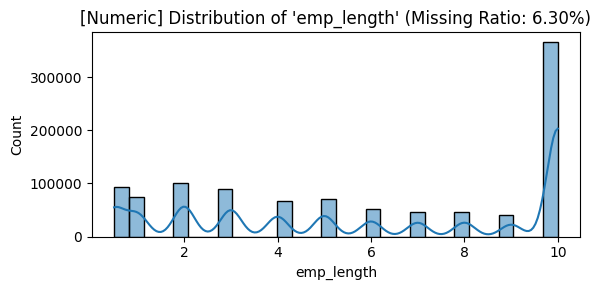

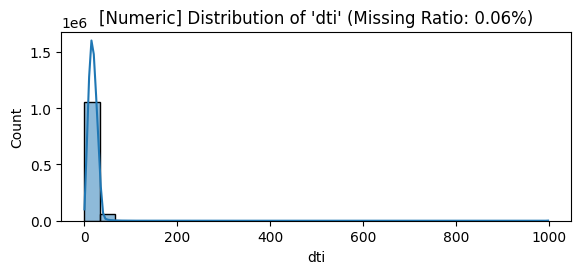

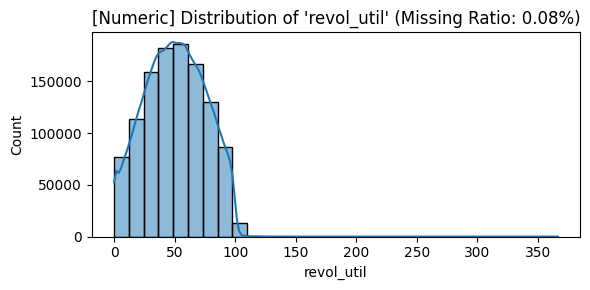

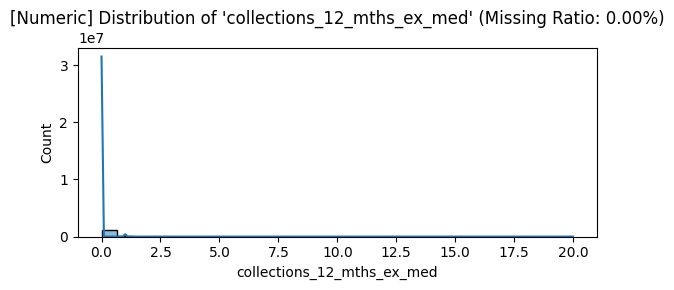

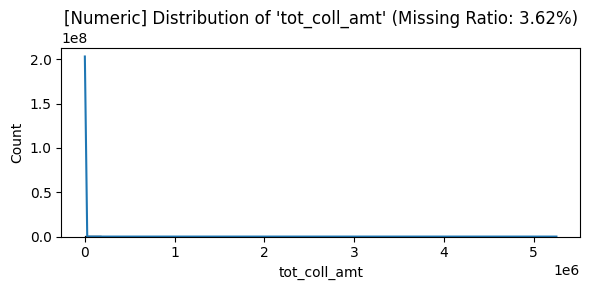

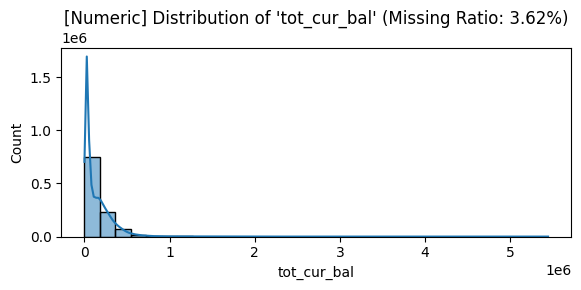

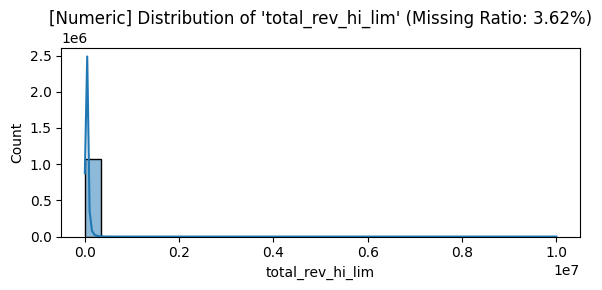

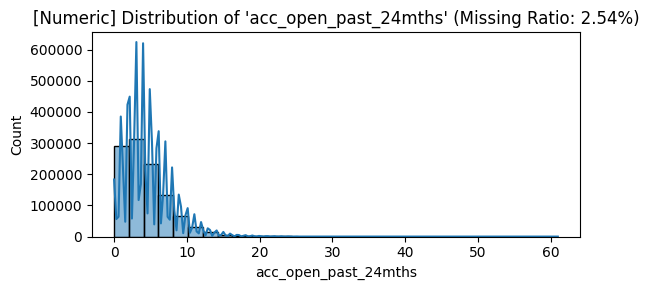

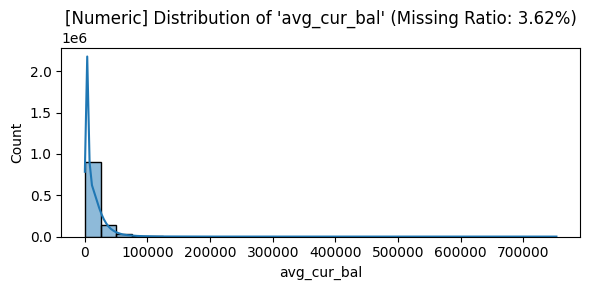

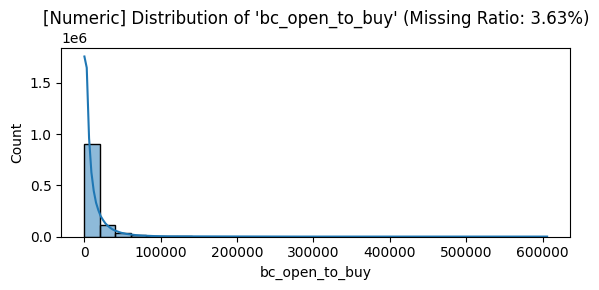

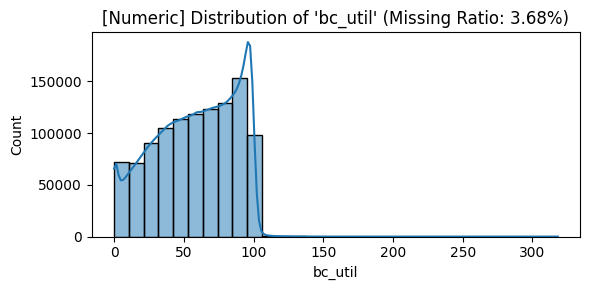

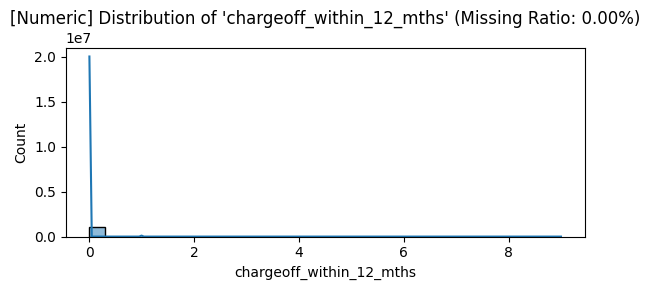

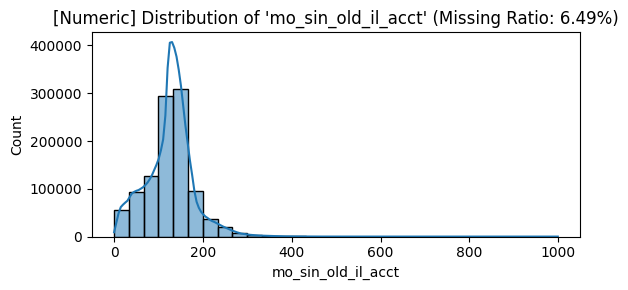

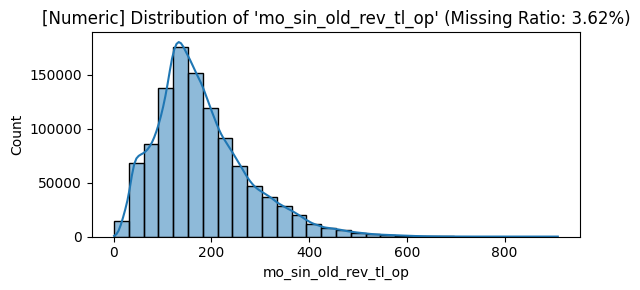

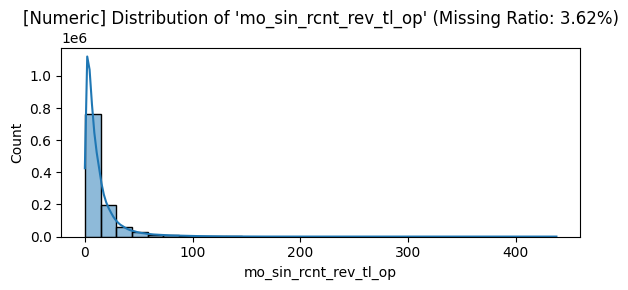

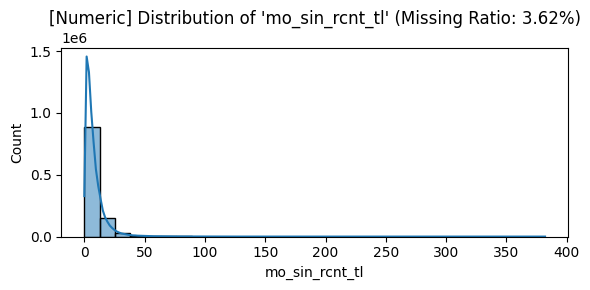

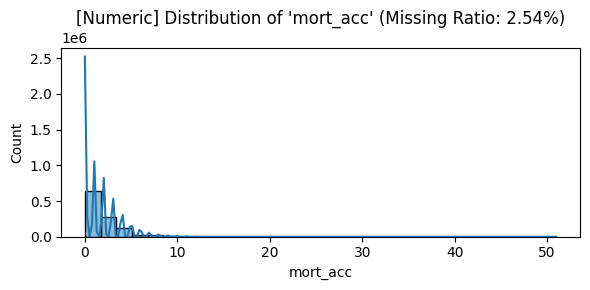

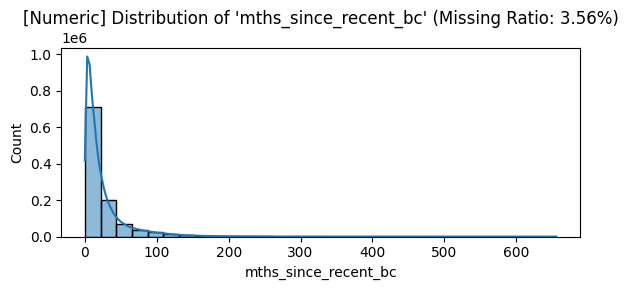

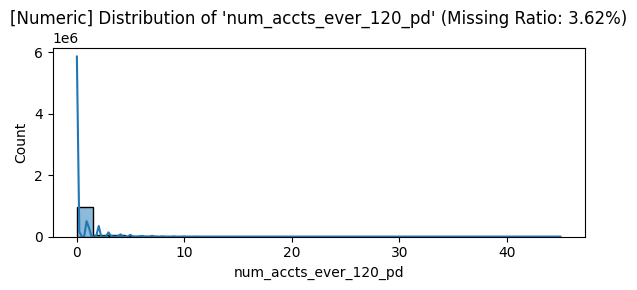

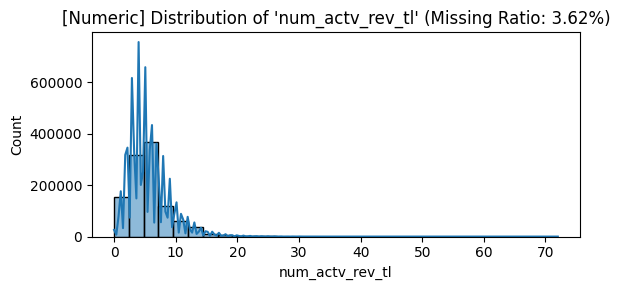

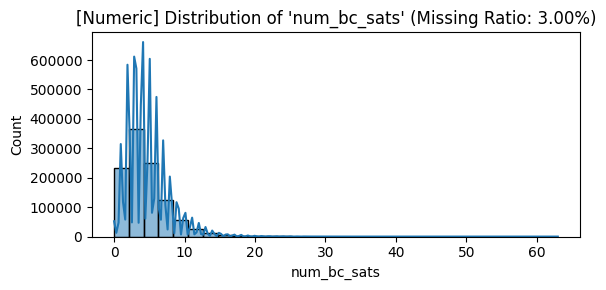

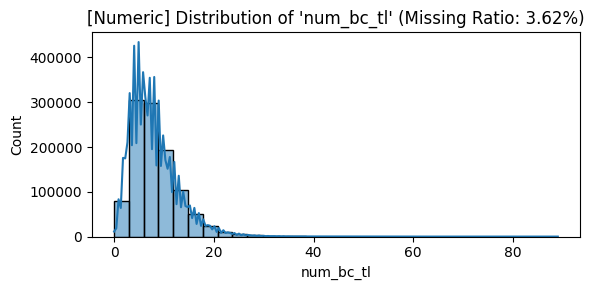

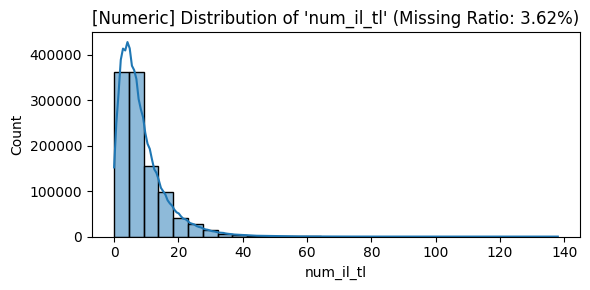

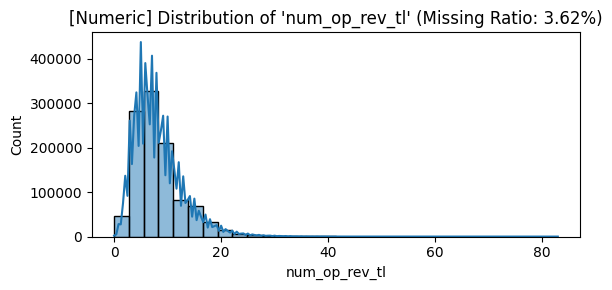

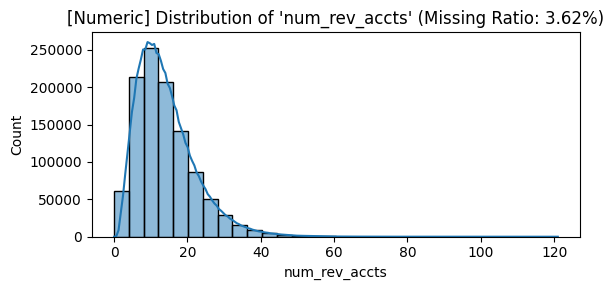

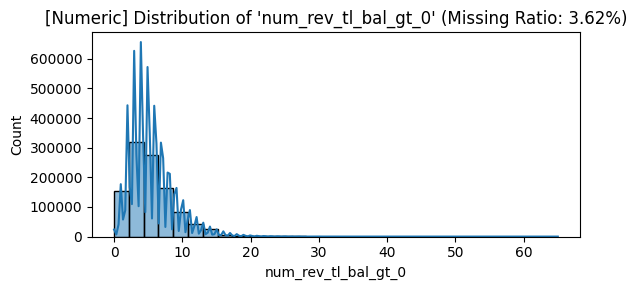

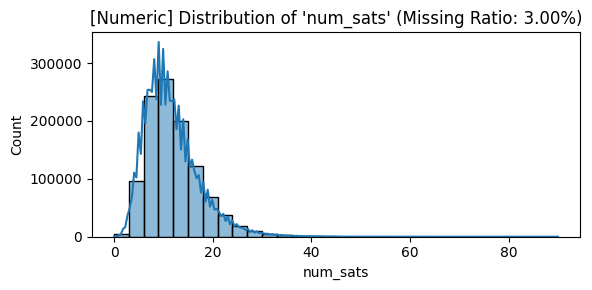

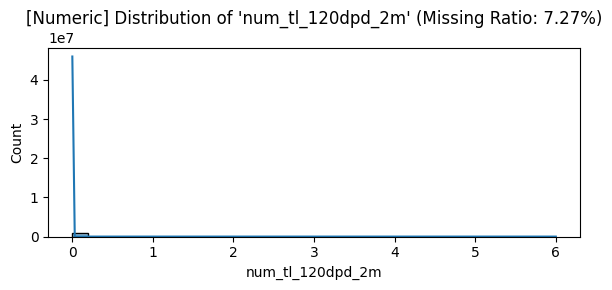

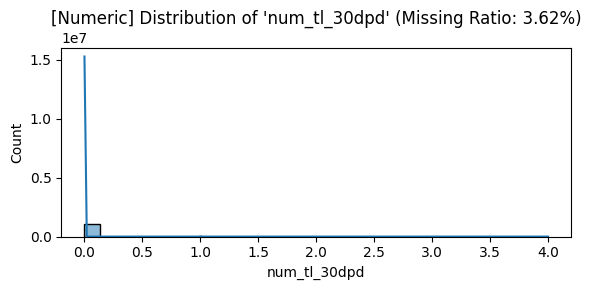

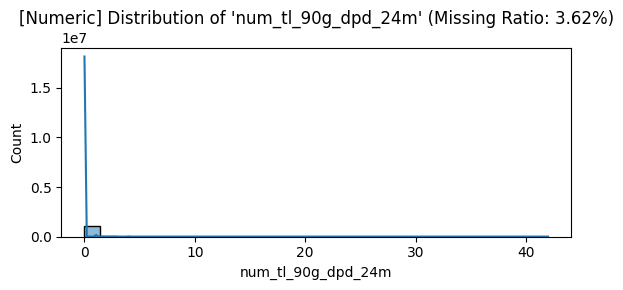

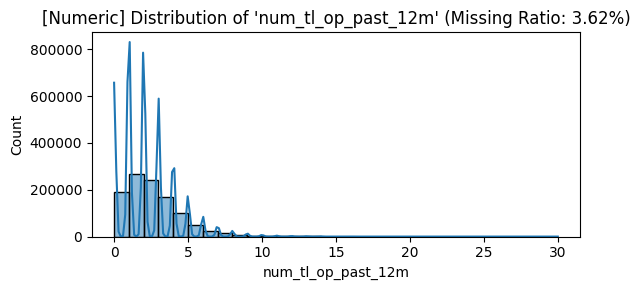

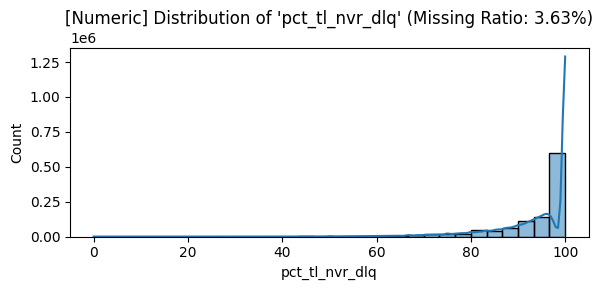

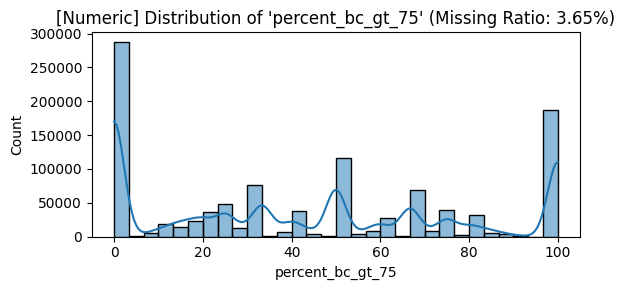

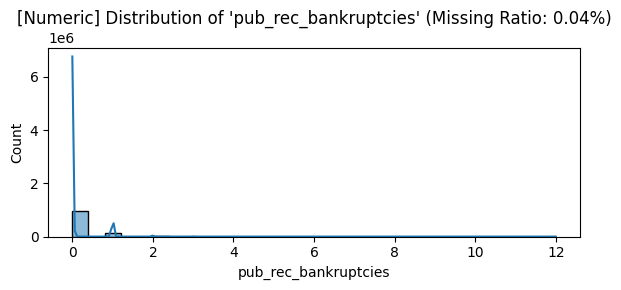

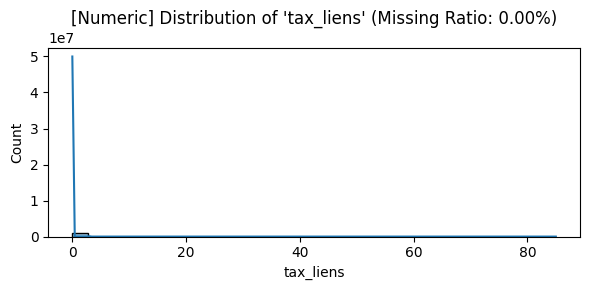

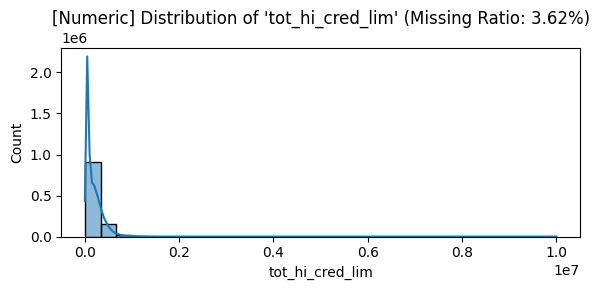

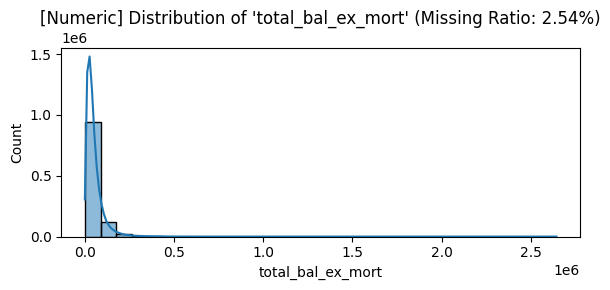

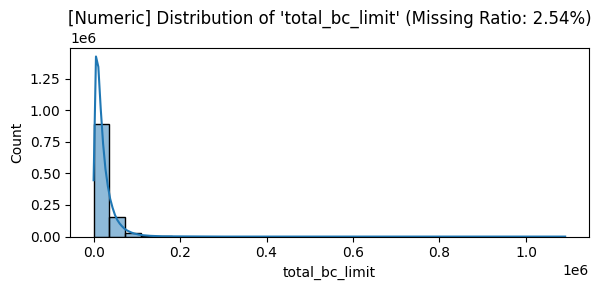

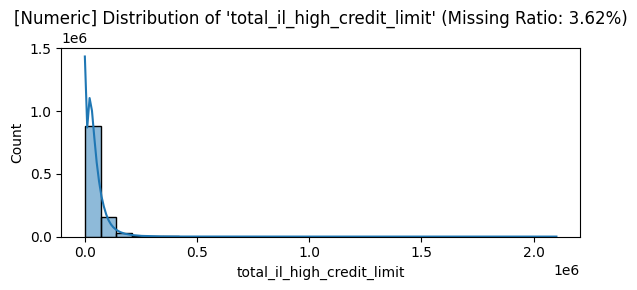

In [9]:
# 결측률 10% 미만인 변수들의 분포를 보여주기

# 시각화
for col in low_missing_cols:
    plt.figure(figsize=(6,3))
    if df[col].dtype in ['float64', 'int64']:
        sns.histplot(df[col].dropna(), bins=30, kde=True)
        plt.title(f"[Numeric] Distribution of '{col}' (Missing Ratio: {missing_ratio[col]:.2%})")
    else:
        sns.countplot(x=col, data=df)
        plt.title(f"[Categorical] Countplot of '{col}' (Missing Ratio: {missing_ratio[col]:.2%})")
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [10]:
# describe 통계량 출력
numeric_summary = df[low_missing_cols].describe().T

# 추가로 결측치 개수와 비율 추가
numeric_summary['missing_count'] = df[low_missing_cols].isnull().sum()
numeric_summary['missing_ratio'] = df[low_missing_cols].isnull().mean()

# 결과 확인
print(numeric_summary)

                                count           mean            std  min  \
emp_length                  1045848.0       5.970756       3.640562  0.5   
dti                         1115510.0      18.580972      13.369402  0.0   
revol_util                  1115316.0      50.458409      24.791103  0.0   
collections_12_mths_ex_med  1116118.0       0.017874       0.150068  0.0   
tot_coll_amt                1075752.0     232.234467    5476.644978  0.0   
tot_cur_bal                 1075752.0  142393.461711  159600.497675  0.0   
total_rev_hi_lim            1075752.0   33758.033310   35330.017739  0.0   
acc_open_past_24mths        1087855.0       4.652558       3.193029  0.0   
avg_cur_bal                 1075723.0   13596.028969   16492.265236  0.0   
bc_open_to_buy              1075645.0   11040.482590   16307.954920  0.0   
bc_util                     1075064.0      58.172741      28.717244  0.0   
chargeoff_within_12_mths    1116118.0       0.008854       0.107176  0.0   
mo_sin_old_i

In [11]:
# 결측률 < 10%인 변수들 전처리

# emp_length: 결측치 = 0 + missing label
df['emp_length_missing'] = df['emp_length'].isnull().astype(int)
df['emp_length'] = df['emp_length'].fillna(0)

# percent_bc_gt_75: 결측치 0 + missing label
df['percent_bc_gt_75_missing'] = df['percent_bc_gt_75'].isnull().astype(int)
df['percent_bc_gt_75'] = df['percent_bc_gt_75'].fillna(0)

# 0으로 채운 변수들
fillna0_cols = ['collections_12_mths_ex_med', 'tot_coll_amt', 'chargeoff_within_12_mths', 'mo_sin_old_il_acct' ]
df[fillna0_cols] = df[fillna0_cols].fillna(0)

# 중앙값으로 채운 변수들
median_replacement_cols = ['tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                           'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
                          'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_rev_tl', 
                           'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 
                           'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 
                           'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
                           'total_bc_limit', 'total_il_high_credit_limit'] 
df[median_replacement_cols] = df[median_replacement_cols].fillna(df[median_replacement_cols].median())


In [12]:
# 결측률 > 10%인 변수들 살펴보기

# 1. 전체 숫자형 변수 목록
numeric_cols = df.select_dtypes(include='number').columns

# 2. 결측률이 10% 미만인 변수 제외
remaining_numeric_cols = list(set(numeric_cols) - set(low_missing_cols))

# 3. 더미 변수(0과 1만 있는 변수) 제외
non_dummy_numeric_cols = [
    col for col in remaining_numeric_cols
    if df[col].dropna().nunique() > 2  # 고유값 개수가 2개 이하인 변수는 제외 (0, 1 또는 상수)
]

print(f"더미 변수 제외한 숫자형 변수 목록: {non_dummy_numeric_cols}")
print(f"개수: {len(non_dummy_numeric_cols)}")

더미 변수 제외한 숫자형 변수 목록: ['grade_num', 'max_bal_bc', 'mths_since_recent_inq', 'il_util', 'inq_last_6mths', 'delinq_2yrs', 'acc_now_delinq', 'open_rv_24m', 'open_acc', 'total_bal_il', 'open_il_12m', 'open_rv_12m', 'all_util', 'mths_since_last_delinq', 'mths_since_rcnt_il', 'inq_last_12m', 'delinq_amnt', 'mths_since_recent_revol_delinq', 'open_il_24m', 'last_fico_range_low', 'sub_grade_num', 'annual_inc', 'open_act_il', 'open_acc_6m', 'last_fico_range_high', 'total_acc', 'fico_range_low', 'pub_rec', 'revol_bal', 'fico_range_high']
개수: 30


In [13]:
# 결측률 10% 이상이 변수들은 일괄적으로 결측값 0 대체+missing indicator 추가
for col in non_dummy_numeric_cols:
    # 결측 여부 표시하는 변수 생성 (1: 결측, 0: 결측 아님)
    df[f'{col}_missing'] = df[col].isnull().astype(int)

    # 결측값을 0으로 대체
    df[col] = df[col].fillna(0)

/var/folders/mc/c2xlw1v55mvcpklv1sgzmldc0000gn/T/ipykernel_66284/3904844.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_missing'] = df[col].isnull().astype(int)
/var/folders/mc/c2xlw1v55mvcpklv1sgzmldc0000gn/T/ipykernel_66284/3904844.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_missing'] = df[col].isnull().astype(int)
/var/folders/mc/c2xlw1v55mvcpklv1sgzmldc0000gn/T/ipykernel_66284/3904844.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [14]:
df = df.drop(columns=['grade', 'sub_grade', 'verification_status_joint'])

In [15]:
df.to_csv('../data/interim/preprocessed_data_Sunyu.csv', index=False)